## Importing the required libraries

In [16]:
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


## Loading the Dataset

In [17]:
# ======== 1. Load and Preprocess Data ========
df = pd.read_csv("diabetes_prediction_dataset.csv")  # 🔁 Replace with your actual file

X = df.drop("diabetes", axis=1)       # 🔁 Replace 'diabetes' with your label
y = df["diabetes"]

# Encode categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le


## Splitting the data

In [18]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling the data

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Handling class imbalance with SMOTE


In [20]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

## Training the models

C:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:42:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


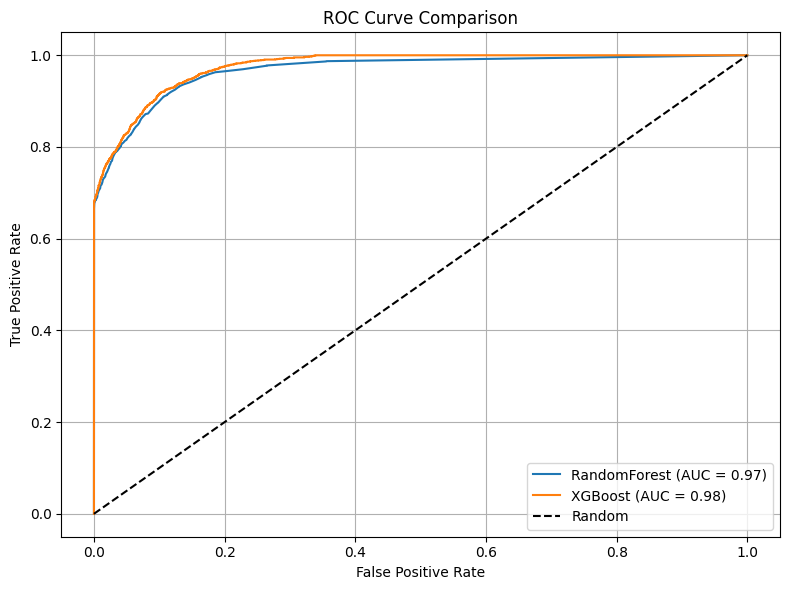

In [22]:
models = {
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        scale_pos_weight=sum(y == 0) / sum(y == 1),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

model_results = {}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    
    model_results[name] = {'model': model, 'auc': auc}
    
    # ✅ Properly indented plotting line
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Customize and display plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Selecting the Best Model by AUC 

In [23]:
best_model_name = max(model_results, key=lambda x: model_results[x]['auc'])
best_model = model_results[best_model_name]['model']
print(f"\n🏆 Best model: {best_model_name}")


🏆 Best model: XGBoost


 ## Fine-tune Threshold 

In [ ]:
proba = best_model.predict_proba(X_test_scaled)[:, 1]

best_threshold = 0.5
best_f1 = 0
for t in np.arange(0.1, 1.0, 0.05):
    preds = (proba >= t).astype(int)
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    f1 = report['1']['f1-score']
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"✅ Best threshold based on F1-score: {best_threshold:.2f} (F1: {best_f1:.4f})")

## Final Prediction and Evaluation 


✅ Confusion Matrix:
[[18259    33]
 [  535  1173]]


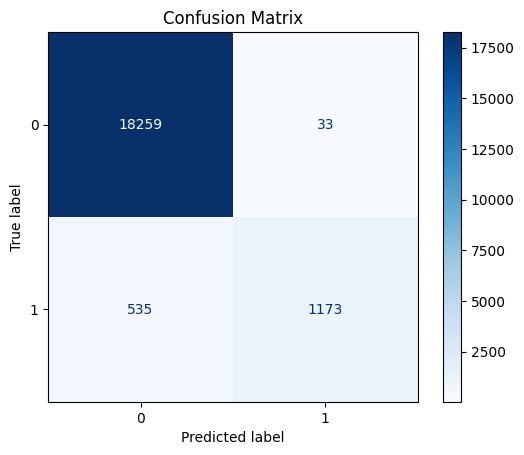


✅ Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.97      0.69      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.97      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

✅ Final predictions saved to final_predictions.csv


In [24]:
final_preds = (proba >= best_threshold).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Print Confusion Matrix as text
print("\n✅ Confusion Matrix:")
cm = confusion_matrix(y_test, final_preds)
print(cm)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")  # Optional: change color map
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print("\n✅ Classification Report:")
print(classification_report(y_test, final_preds, zero_division=0))

# Save predictions to CSV
results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": final_preds,
    "Probability_Class_1": proba
})
results_df.to_csv("final_predictions.csv", index=False)
print("✅ Final predictions saved to final_predictions.csv")

## Save Best Model, Scaler, and Threshold

In [25]:
package = {
    "model": best_model,
    "scaler": scaler,
    "threshold": best_threshold,
    "label_encoders": label_encoders,
    "model_name": best_model_name
}
joblib.dump(package, "best_model_package.pkl")
print("✅ Best model, scaler, and threshold saved to best_model_package.pkl")


✅ Best model, scaler, and threshold saved to best_model_package.pkl
